In [41]:
import os
import json
import subprocess
import traceback

import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import statistics

import mne
import scipy
import json

import pandas as pd
import numpy as np

from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from os import walk
from collections import Counter

In [42]:
def extract_strict_sectors(edf, sector_length): # Returns sectors[begin,end] and labels
	"""
	Extract sectors of the given length using begin and start labels.
	Sample usage is extracting sectors of length 600 ms (1000Hz).
	"""
	# 1n восприятие / n проговаривани
    
	sectors = []
	labels = []
	invalid_labels = []
	last_sector_end_index = None
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]
  
	for index, (timestamp, value) in enumerate(zip(X, Y)):
		if value > 0:
			
			if last_sector_end_index is not None and index < last_sector_end_index:
				invalid_labels.append(index)
				continue
			
			# Assume that sector [index : index+sector_length] does not 
			#  intersect with other sector [index2 : index2+sector_length]
			value = int(value)
			
			# Phoneme begin 
			if value // 10 == 0:
				if index + sector_length > len(X):
					invalid_labels.append(index)
					continue
				
				# Append sector from current position to current+sector_length as sector
				sectors.append((index, index + sector_length))
				labels.append(value % 10)
				last_sector_end_index = index + sector_length
			
			# Phoneme end
			elif value // 10 == 1:
				# Ignore underflow
				if index - sector_length < 0:
					invalid_labels.append(index)
					continue
				
				# Append sector from current position to current+sector_length as sector
				sectors.append((index - sector_length, index))
				labels.append(value % 10)
				last_sector_end_index = index
	
	return sectors, invalid_labels, labels

In [43]:
def extract_strict_sectors(edf, sector_length = 600 ): # Returns sectors[begin,end] and labels
	"""
	Extract sectors of the given length using begin and start labels.
	Sample usage is extracting sectors of length 600 ms (1000Hz).

	1n восприятие / n проговаривани
	"""
	sectors = []
	labels = []

	number_of_current_phoneme = None
	counter = 0
	silent_speach = False
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]
  
	for index, (timestamp, value) in enumerate(zip(X, Y)):
		counter-=1 
		if value > 0:
			value = int(value)
			
			# Phoneme begin 
			if value // 10 == 0:
				counter = sector_length
				number_of_current_phoneme = value % 10
				silent_speach = True
			else:
				silent_speach = False

		if silent_speach and counter == 0:
			sectors.append((index - sector_length, index))
			labels.append(number_of_current_phoneme)
	
	return sectors, 0, labels

### Открываем файлы

In [47]:
myography_prosebaya_path = '../../data/eeg_mio/converted/Prosebaya'
myography_vsluh_path = '../../data/eeg_mio/converted/Vsluh'

In [48]:
myography_prosebaya_filenames = sorted(next(walk(myography_prosebaya_path), (None, None, []))[2])
myography_vsluh_filenames = sorted(next(walk(myography_vsluh_path), (None, None, []))[2])

In [49]:
edf_prosebaya = []
for filename in myography_prosebaya_filenames:
    file_with_path = f'{myography_prosebaya_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_prosebaya.append(edf)

edf_vsluh = []    
for filename in myography_vsluh_filenames:
    file_with_path = f'{myography_vsluh_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_vsluh.append(edf)

Extracting EDF parameters from /home/admsys/Projects/data/eeg_mio/converted/Prosebaya/AbrosimovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/admsys/Projects/data/eeg_mio/converted/Prosebaya/AlyaksinaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/admsys/Projects/data/eeg_mio/converted/Prosebaya/MorozovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/admsys/Projects/data/eeg_mio/converted/Prosebaya/NoginaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/admsys/Projects/data/eeg_mio/converted/Prosebaya/RadionF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E

In [8]:
myography_prosebaya_filenames, myography_vsluh_filenames

(['AbrosimovaF_ProsebyaChist.edf',
  'AlyaksinaF_ProsebyaChist.edf',
  'MorozovaF_ProsebyaChist.edf',
  'NoginaF_ProsebyaChist.edf',
  'RadionF_ProsebyaChist.edf',
  'TankaevF_ProsebyaChist.edf'],
 ['AbrosimovaF_VsluhChist.edf',
  'AlyaksinaF_VsluhChist.edf',
  'MorozovaF_VsluhChist.edf',
  'NoginaF_VsluhChist.edf',
  'RadionF_VsluhChist.edf',
  'TankaevF_VsluhChist.edf'])

#  Преоразовываем данные для дальнейней работы

В этом блоке общая информация о данных и выделение сектора длиной SECTOR_LENGTH с внутр. проговариванием по каналу метка 

### В файле содержатся каналы, отвечающие на ЭЭГ и ЭМГ

ЭЭГ - в файле много каналов, но нам нужны только эти - F7, F3, T3, C3 ( каналы отвечащие за речь )

ЭМГ - Oz, Fpz (гортань, над губой)

In [9]:
TARGET_CHANNELS = 4
TARGET_CHANNEL_SETS = [
	[ 'EEG F7-A1', 'EEG F7-M1' ],
	[ 'EEG F3-A1', 'EEG F3-M1' ],
	[ 'EEG T3-A1', 'EEG T3-M1' ],
	[ 'EEG C3-A1', 'EEG C3-M1' ],
]

TARGET_MYOGRAPHY_CHANNEL_SETS  = [
    ['EEG Oz-A2','EEG Oz-M2'],
    ['EEG Fpz-A2','EEG Fpz-M2']
]

SECTOR_LENGTH = 600

In [10]:
print(f'Available channels: {edf_prosebaya[0].ch_names}')

Available channels: ['EEG O1-M1', 'EEG O2-M2', 'EEG P3-M1', 'EEG P4-M2', 'EEG C3-M1', 'EEG C4-M2', 'EEG F3-M1', 'EEG F4-M2', 'EEG Fp1-M1', 'EEG Fp2-M2', 'EEG T5-M1', 'EEG T6-M2', 'EEG T3-M1', 'EEG T4-M2', 'EEG F7-M1', 'EEG F8-M2', 'EEG Fz-M1', 'EEG Cz-M2', 'EEG Pz-M1', 'EEG Oz-M2', 'EEG Fpz-M2', 'METKA']


In [11]:
def get_channel_edf(edf, name_channel):
    channel = edf[name_channel]
    Y_channel = list(channel[0][0])
    X_channel = channel[1]
    return X_channel, Y_channel
    
def plot_channel_edf(edf, name_channel):
    fig, ax = plt.subplots()
    Y_channel = get_channel_edf(edf, name_channel)[1]
    ax.plot(Y_channel)
    ax.set_title(f'Chanel {name_channel}', weight='bold', fontsize = 15)
    fig.set_figwidth(20)

Рассмотрим одного человека

In [12]:
efd_person = edf_prosebaya[0]

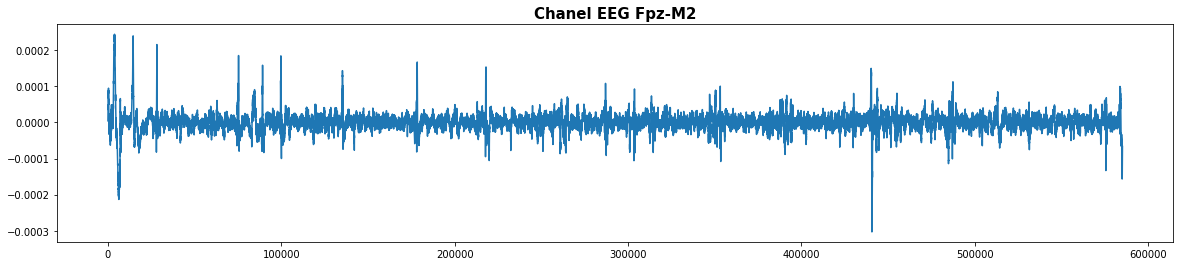

In [13]:
plot_channel_edf(efd_person,'EEG Fpz-M2') # ЭМГ КАНАЛ 

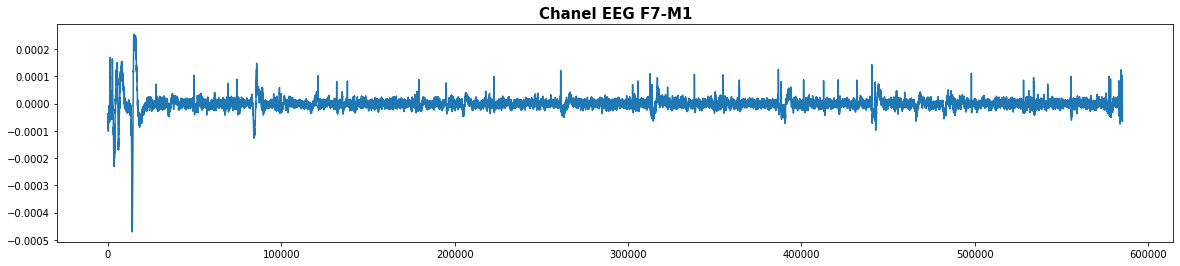

In [14]:
plot_channel_edf(efd_person,'EEG F7-M1') # ЭЭГ КАНАЛ 

In [15]:
def plot_labels(edf, missing_labels):
	"""
	Plot distribution of valid and invalid labels
	"""
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]
	
	plt.rcParams["figure.figsize"] = (25, 5)
	plt.rcParams["font.size"] = 14

	for index in range(len(X)):
		if Y[index] > 0:
			if index in missing_labels:
				plt.scatter(X[index], Y[index], color='red', marker='x')
			else:
				plt.scatter(X[index], Y[index], color='blue', marker='.')

	plt.show()

In [16]:
# выделяем сектора с внутр. проговариванием по метка => получаем сектора длины = SECTOR_LENGTH
sectors, invalid_sectors, labels = extract_strict_sectors(efd_person, SECTOR_LENGTH)

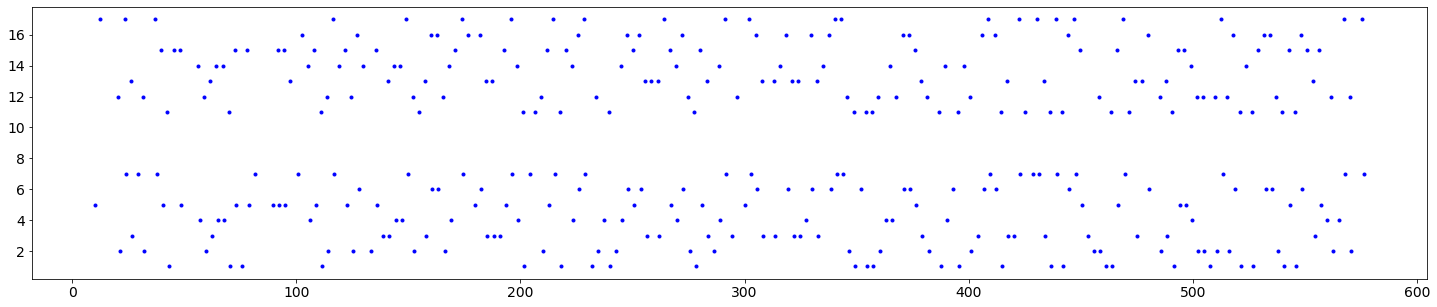

In [17]:
plot_labels(efd_person, labels)

Посмотрим на какой-нибудь сектор из sectors

In [18]:
sector = sectors[15]

a, b  = sector
sectors_channel_Fpz = get_channel_edf(efd_person,'EEG Fpz-M2')[1][a:b]
sectors_channel_Oz =  get_channel_edf(efd_person,'EEG Oz-M2')[1][a:b]
sectors_channel_F7 =  get_channel_edf(efd_person,'EEG F7-M1')[1][a:b]

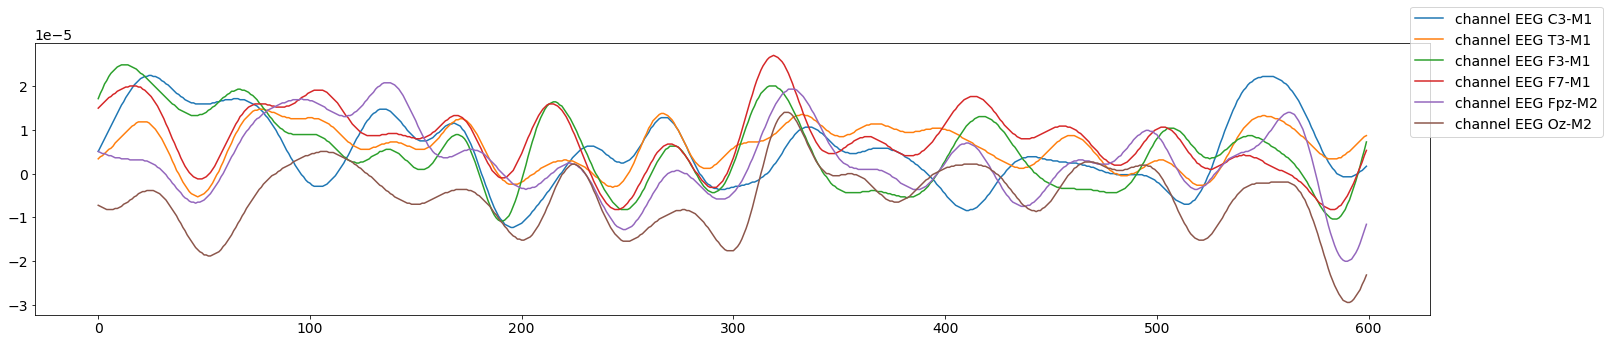

In [19]:
# выведем все каналы в секторе для одного человека в иследовании Просебя
fig, ax = plt.subplots()

sectors_channels = ['EEG C3-M1', 'EEG T3-M1', 'EEG F3-M1', 'EEG F7-M1', 'EEG Fpz-M2','EEG Oz-M2' ]
for channel in sectors_channels:
    sectors_channel = get_channel_edf(efd_person,channel)[1][a:b]
    ax.plot(sectors_channel, label = f'channel {channel}')
fig.legend()

# Кореляция 

### Cтационарность
если просто -  означает, что статистические свойства процесса не меняются со временем

Ряд считается стационарным, если:
 - E(X) = const
 - σ = const
 - нет тренда, сезонности ..



Способы сделать ряд стационарным:

- дифференцирование          - np.diff()
- логарифмирование           - np.log()
- взятие корня               - np.sqpt()
- пропорциональное изменение - df.shift(1)/df

In [20]:
from statsmodels.tsa.stattools import adfuller

''' Тест Дики — Фуллера для проверки стационарности
'''
# проверка на стационарность, если P-value < 0.05 => стационарный
def adf_test(timeserie):
    dftest = adfuller(timeserie, autolag='AIC')
    p_value = pd.Series(dftest[1])
    if (p_value < 0.05).bool():
        return True
    else:
        return False  

def make_timeserie_stationary(timeserie):
    ch_log = np.sqrt(timeserie)
    ch_log = ch_log[~np.isnan(ch_log)]
    return np.diff(ch_log)

def make_timeserie_stationary_diff(timeserie):
    timeserie = np.diff(timeserie)
    i = 0
    while not adf_test(timeserie):
        i+= 1
        timeserie = np.diff(timeserie)
    return timeserie, i 

# тк ряд содержит нулевые и отрицательные значения, мы поднимаем его на константу, а потом вычитаем
def make_timeserie_stationary_sqpt(timeserie, const = 5):
    timeserie += const
    return np.sqrt(timeserie)

# TODO: попробовать для всех одинак раз дифф
def check_and_make_timeserie_stationary(timeserie):
    if not adf_test(timeserie):
        return make_timeserie_stationary_diff(timeserie)[0] #0 => выводим только ряд
    return timeserie

## Корреляция каналов Oz и F7 выбранных сегментов

In [21]:
# проверяем на стацонарность и находим значение корреляции с лагом
def  get_correlation_sector(first, second):
    first = check_and_make_timeserie_stationary(first) 
    second = check_and_make_timeserie_stationary(second) 

    f = (first - np.mean(first)) / (np.std(first) * len(first))
    s = (second - np.mean(second)) / (np.std(second))  
    corr = np.correlate(f, s, 'full')
    
    lags = signal.correlation_lags(len(first), len(second), mode = 'full')
    zip_corr_lags = zip(corr,lags)
    
    # находим максимальное значение корреляции с соответсв. ему лагом
    max_corr_with_lags = sorted(zip_corr_lags, key = lambda x: x[0], reverse = True)[0]
    
    return max_corr_with_lags

### Подсчитаем значения корреляции во всех секторах внутреннего проговаривания для одного человека

In [22]:
def get_correlations(efd_person, first_channel, second_channel, sectors):
    '''
    return array of typle - (ccf,lags)
    '''
    first_channel = get_channel_edf(efd_person,first_channel )[1]
    second_channel =  get_channel_edf(efd_person,second_channel )[1]

    only_pronunciation_in_channels = []
    
    # выделяем секторы
    for begin, end in sectors:
        only_pronunciation_in_channels.append([first_channel[begin:end],second_channel[begin:end]])

    correlations = []
    
    # проверяем на стацонарность и находим значение корреляции с лагом
    for first, second in only_pronunciation_in_channels:
        correlation = get_correlation_sector(first , second)
        correlations.append(correlation)
    return correlations


def plot_correlations_for_person(correlations):
    fig, ax = plt.subplots()

    unzip_correlations = list(zip(*correlations)) # from typle to two array

    correlations = unzip_correlations[0]
    lags = unzip_correlations[1]

    ax.plot(correlations, lags, 'ro')
    ax.set_title(f'Значения кореляций всех прогованиваний одного испытуемого в каналах {first_channel } и {second_channel} ', weight='bold', fontsize = 15)
    ax.set_xlabel('Correlation', weight='bold', fontsize = 12)

1. Кореляция каналов Fpz и Oz

In [23]:
first_channel  = 'EEG Oz-M2' # 'EEG Fpz-M2'
second_channel = 'EEG F7-M1' # 'EEG C3-M1' 'EEG T3-M1' 'EEG F3-M1' 'EEG F7-M1'

efd_person = edf_prosebaya[0]
sectors, invalid_sectors, labels = extract_strict_sectors(efd_person, SECTOR_LENGTH)

correlations = get_correlations(efd_person, first_channel, second_channel, sectors)

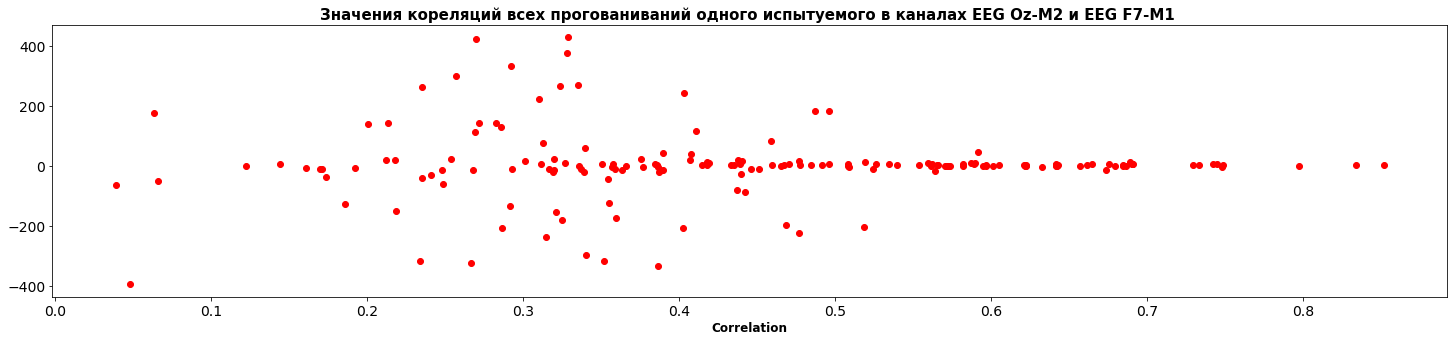

In [24]:
plot_correlations_for_person(correlations)

# Нахождение корреляции данных 

### Структура данных для одного испытуемого

рассмотрим данные "По себя"
данные представляют собой словарь:
- канал ЭЭГ - канал ЭМГ - (корреляция, лаг)

{ 'EEG-C3' : {'EEG Fpz-M2': [.(список (корреляция, лаг)).], 'EEG Oz-M2': [...] }, 
  'EEG-T3' : {'EEG Fpz-M2': [...], 'EEG Oz-M2': [...]  

In [25]:
eeg_channels = ['EEG C3-M1', 'EEG T3-M1', 'EEG F3-M1', 'EEG F7-M1' ]
emg_channels = ['EEG Fpz-M2','EEG Oz-M2' ]

def get_all_person_correlations(person_edf, eeg_channels, emg_channels, sector_length):
    sectors, invalid_sectors, labels = extract_strict_sectors(person_edf, sector_length) 
        
    EEGs = {}
    for emg in eeg_channels:
        EMGs = {}
        for eeg in emg_channels:
            correlations = get_correlations(person_edf, emg, eeg, sectors)
            EMGs[eeg] = correlations
        EEGs[emg] = EMGs
    return EEGs


# ! данные edf_prosebaya и edf_vsluh упорядочены так, что порядковый номер соотв. одному и тому же человеу
def get_all_correlations(edf_prosebaya, edf_vsluh, eeg_channels, emg_channels, sector_length):
    '''
    для каждого человека находим значения корреляции по данным "про себя"\ "вслух" 
    '''
    res = []
    for i_person in range(len(edf_prosebaya)):
        prosebaya_corr_dir = get_all_person_correlations(edf_prosebaya[i_person], eeg_channels, emg_channels, sector_length)
        vsluh_corr_dir = get_all_person_correlations(edf_vsluh[i_person], eeg_channels, emg_channels, sector_length)
        res.append([prosebaya_corr_dir, vsluh_corr_dir])
    return res  

In [26]:
all_correlations = get_all_correlations(edf_prosebaya, edf_vsluh, eeg_channels, emg_channels, SECTOR_LENGTH)

###  Сводка по данным

In [27]:
print('Кол-во испытуемых: ',len(all_correlations))
#print('"про себя" "вслух: ',len(all_correlations[0]))
print('Кол-во ЭЭГ каналов: ',len(all_correlations[0][0]))
print('Кол-во ЭMГ каналов: ',len(all_correlations[0][0]['EEG C3-M1']))
print('Кол-во секторов в канале: ',len(all_correlations[0][0]['EEG C3-M1']['EEG Fpz-M2']))

Кол-во испытуемых:  6
Кол-во ЭЭГ каналов:  4
Кол-во ЭMГ каналов:  2
Кол-во секторов в канале:  173


In [28]:
correlations = all_correlations

In [29]:
def split_data_into_corr_lag(person, chanel):
    '''
    на входе данные к канале - по каждому каналу ЭЭГ - typle(корреляция, лаг)
    перезаписываем для отображения на графике, как отдельные массивы - корреляция, лаг
    '''
    correlations = []
    lags = []
    unzip_correlations = list(zip(*chanel)) # from typle to two array
    correlations.append(unzip_correlations[0])
    lags.append(unzip_correlations[1])
    return correlations, lags

In [30]:
all_persons_dataplot = []
for person in correlations:

    df_prosebaya = {}
    for name_eeg, eeg_prosebaya in person[0].items():
        for name_emg, corr in eeg_prosebaya.items():
            split_data = split_data_into_corr_lag(person, corr)
            df_prosebaya['prosebaya | corr ' + name_eeg + ' & ' + name_emg] = split_data[0][0]
            #df_prosebaya['lag ' + name_eeg + ' & ' + name_emg] = split_data[1][0]
             
    df_vsluh = {}
    for name_eeg, eeg_vsluh in person[1].items():
        for name_emg, corr in eeg_prosebaya.items():
            split_data = split_data_into_corr_lag(person, corr)
            df_vsluh['vsluh  |corr ' + name_eeg + ' & ' + name_emg] = split_data[0][0]
            #df_vsluh['lag ' + name_eeg + ' & ' + name_emg] = split_data[1][0]
    
    df_prosebaya = pd.DataFrame(df_prosebaya)
    df_vsluh = pd.DataFrame(df_vsluh)
    all_persons_dataplot.append([df_prosebaya,df_vsluh  ])

In [31]:
all_persons_dataplot[0][0].head()

,prosebaya | corr EEG C3-M1 & EEG Fpz-M2,prosebaya | corr EEG C3-M1 & EEG Oz-M2,prosebaya | corr EEG T3-M1 & EEG Fpz-M2,prosebaya | corr EEG T3-M1 & EEG Oz-M2,prosebaya | corr EEG F3-M1 & EEG Fpz-M2,prosebaya | corr EEG F3-M1 & EEG Oz-M2,prosebaya | corr EEG F7-M1 & EEG Fpz-M2,prosebaya | corr EEG F7-M1 & EEG Oz-M2
0,0.384729,0.352843,0.408654,0.411189,0.380414,0.404717,0.591039,0.641905
1,0.358862,0.323496,0.310709,0.259694,0.409569,0.289100,0.293838,0.335896
2,0.398134,0.279386,0.406494,0.481368,0.357104,0.296090,0.406179,0.534587
3,0.217770,0.325042,0.341410,0.329681,0.228946,0.311999,0.219771,0.322974
4,0.281534,0.327553,0.314969,0.278808,0.287036,0.428409,0.259547,0.354462


In [32]:
def plot_person(df_prosebaya, df_vsluh, title):
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_subplot(111)

    bp_vsluh = ax.boxplot(
        df_vsluh,
        patch_artist = True,
        notch ='True', 
        vert = 0, 
        positions = range(0,16, 2),
        labels=[*df_vsluh]
                   )
    bp_prosebaya = ax.boxplot(
        df_prosebaya,
        patch_artist = True,
        notch ='True', 
        vert = 0, 
        positions = range(1,17, 2),
        labels=[*df_prosebaya]
                   )

    plt.setp(bp_vsluh["boxes"], facecolor='#4974a5',)
    plt.setp(bp_prosebaya["boxes"], facecolor='#A54974')

    plt.title(title)

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.set_xlabel('correlation')
    ax.set_ylabel('channels for which the correlation is calculated')

    plt.show()

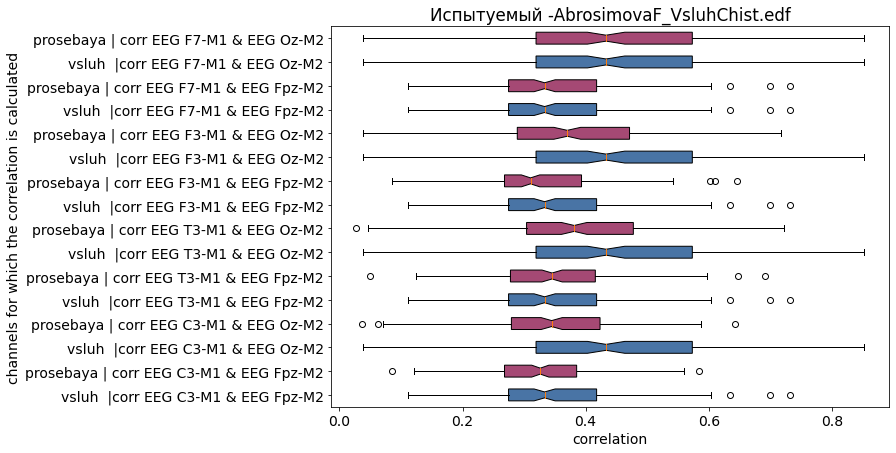

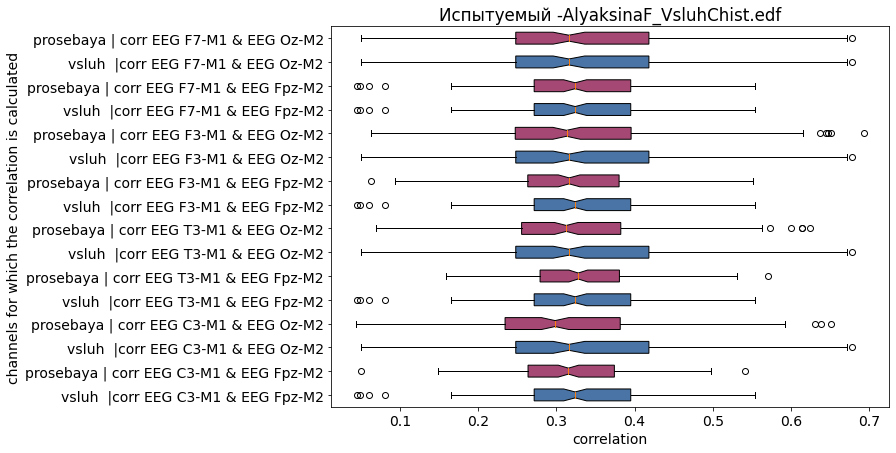

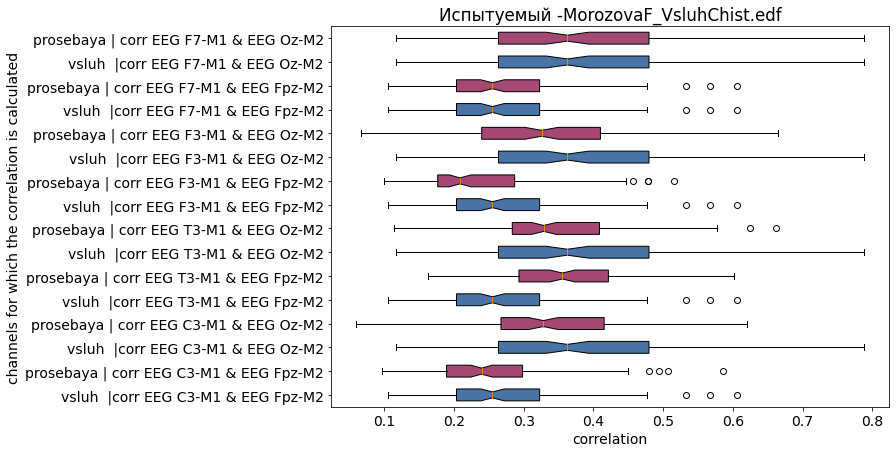

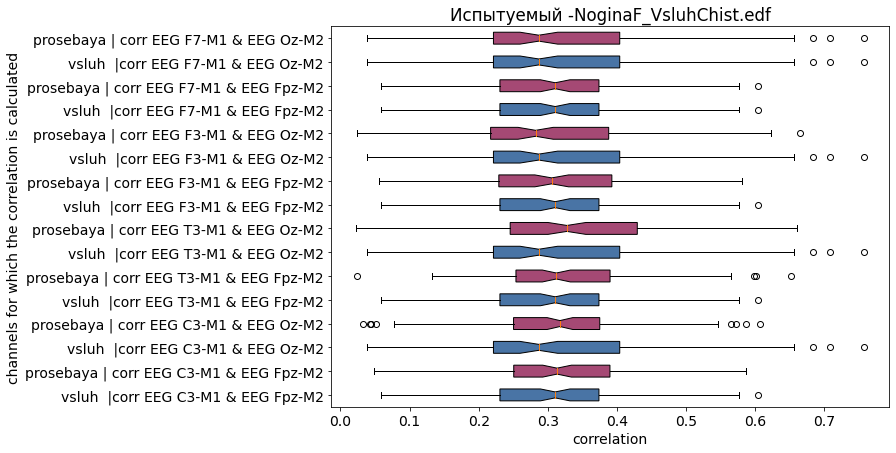

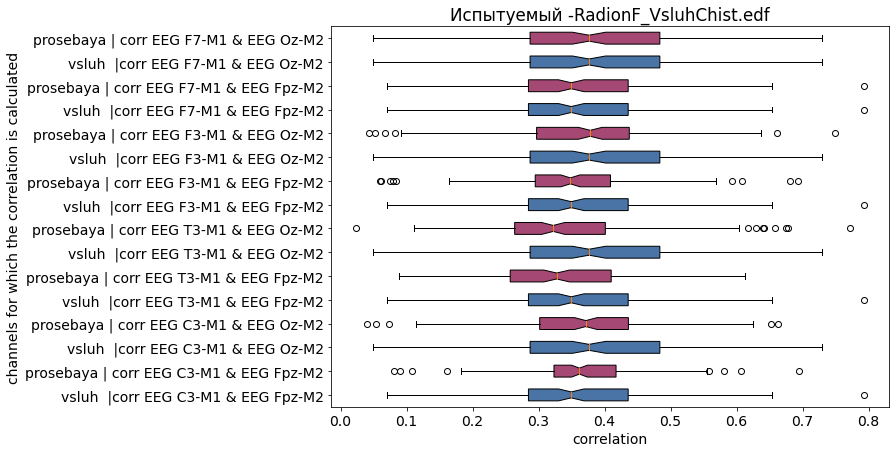

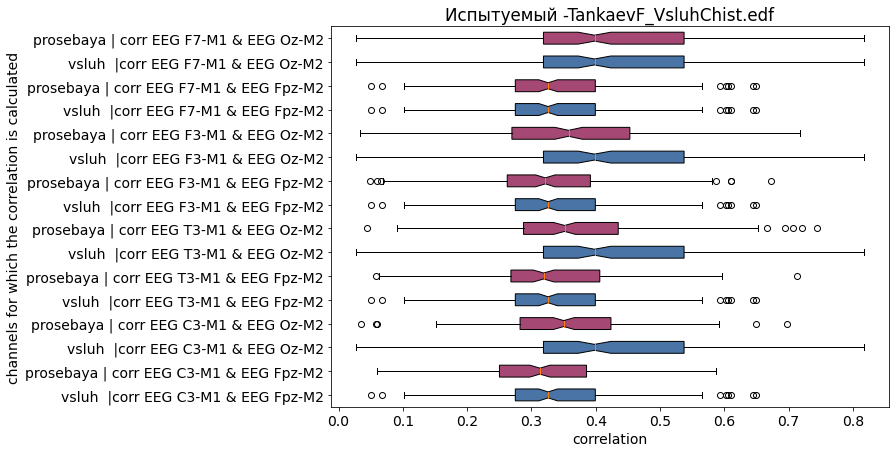

In [33]:
i = 0
for df_prosebaya, df_vsluh in all_persons_dataplot:
    plot_person(df_prosebaya, df_vsluh, f'Испытуемый -{myography_vsluh_filenames[i]}')
    i+=1

____________________________________________________________________________________

##  Значения корреляций каналов ЭМГ данных "Вслух" и  "Про себя"

In [34]:
emg_channels = ['EEG Fpz-M2','EEG Oz-M2' ]

# ! данные edf_prosebaya и edf_vsluh упорядочены так, что порядковый номер соотв. одному и тому же человеу
def get_all_correlations_between_emg(edf_prosebaya, edf_vsluh, emg_channels, sector_length):
    '''
    для каждого человека находим значения корреляции по данным "про себя"\ "вслух" 
    '''
    res = []
    for i_person in range(len(edf_prosebaya)):
        # знаем, что у нас два канала
        first_emg = emg_channels[0]
        second_emg = emg_channels[1]
        
        sectors_prosebaya, invalid_sectors, labels = extract_strict_sectors(edf_prosebaya[i_person], sector_length)
        prosebaya_corr_dir_between_emg =  get_correlations(edf_prosebaya[i_person], first_emg, second_emg, sectors_prosebaya)
      
        #-------
        sectors_vsluh, invalid_sectors, labels = extract_strict_sectors(edf_vsluh[i_person], sector_length)
        vsluh_corr_dir_between_emg =  get_correlations(edf_vsluh[i_person], first_emg, second_emg, sectors_vsluh)
        
        
        res.append([prosebaya_corr_dir_between_emg, vsluh_corr_dir_between_emg])
    return res 

In [35]:
all_correlations_between_emg = get_all_correlations_between_emg(edf_prosebaya, edf_vsluh, emg_channels, SECTOR_LENGTH)

In [36]:
print('Кол-во испытуемых: ',len(all_correlations_between_emg))
print('Кол-во секторов в канале: ',len(all_correlations_between_emg[0][0]))

Кол-во испытуемых:  6
Кол-во секторов в канале:  173


In [37]:
all_persons_dataplot_between_emg = []

for i in range(len(all_correlations_between_emg)):
    
    person = all_correlations_between_emg[i]
    name = f'Испытуемый - {i}'
    
    emg_prosebaya = person[0]
    emg_vsluh = person[1]
        
    df_prosebaya_emg = {}
    split_data_prosebaya = split_data_into_corr_lag(person, emg_prosebaya)
    df_prosebaya_emg[f'prosebaya | corr_emg {name}'] = split_data_prosebaya[0][0]
             
    df_vsluh_emg = {}
    split_data_vsluh = split_data_into_corr_lag(person, emg_vsluh)
    df_vsluh_emg[f'vsluh | corr_emg {name}'] = split_data_vsluh[0][0]

    
    df_prosebaya_emg = pd.DataFrame(df_prosebaya_emg)
    df_vsluh_emg = pd.DataFrame(df_vsluh_emg)
    all_persons_dataplot_between_emg.append([df_prosebaya_emg,df_vsluh_emg])

In [38]:
all_persons_dataplot_between_emg[1][1].head()

,vsluh | corr_emg Испытуемый - 1
0,0.419716
1,0.368974
2,0.353121
3,0.394667
4,0.325107


In [39]:
def plot_emg(all_persons_dataplot_between_emg):
    fig = plt.figure(figsize =(10, 11))
    ax = fig.add_subplot(111)
    
    i = 0
    for df_prosebaya, df_vsluh in all_persons_dataplot_between_emg:
        df_vsluh = ax.boxplot(
                    df_vsluh,
                    patch_artist = True,
                    notch ='True', 
                    vert = 0, 
                    positions = range(i,i+1),
                    labels=[*df_vsluh])
        i+=1
        df_prosebaya = ax.boxplot(
            df_prosebaya,
            patch_artist = True,
            notch ='True', 
            vert = 0,
            positions = range(i,i+1),
            labels=[*df_prosebaya],
            boxprops=dict(facecolor='#A54974'),)
        i+=1

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    plt.title("Сorrelation between EMG chanels")
    
    ax.set_xlabel('correlation')
    
    plt.show()

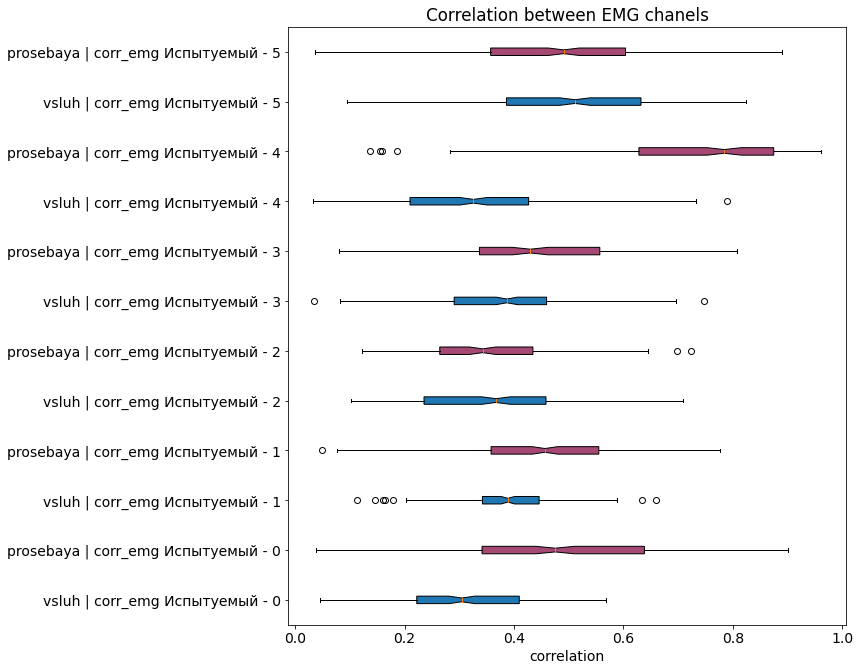

In [40]:
plot_emg(all_persons_dataplot_between_emg)